<a href="https://colab.research.google.com/github/PinkHedgehog/Semantic-segmentation-of-small-objects/blob/master/Segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     |████████████████████████████████| 51kB 905kB/s 
     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=223dbb2788b001b7e4b5d94a36d8df710c92b910cac439be766e5c9d29621c83
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=c7ce0235128490e0e2511b9d1f777abcaeae8a3f6b0f49c2af5a62e12068b8f3
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-oleev9dj
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-oleev9dj
     |████████████████████████████████| 952kB 1.4MB/s 
  Create

In [ ]:
import os
import random
filenames = list(os.listdir('/content/drive/My Drive/1000576_train'))
random.shuffle(filenames)
print(len(filenames), filenames)
test_len = int(0.1*len(filenames))
test_filenames = filenames[-test_len:]
test_filenames = sorted(test_filenames)
valid_len = int(0.1*(len(filenames)-len(test_filenames)))
valid_filenames = filenames[-(test_len+valid_len):-test_len]
valid_filenames = sorted(valid_filenames)
train_filenames = filenames[:-(test_len+valid_len)]
train_filenames = sorted(train_filenames)
print(test_len, valid_len, len(train_filenames))

204 ['323.png', '139.png', '83.png', '277.png', '255.png', '167.png', '287.png', '385.png', '166.png', '1105.png', '312.png', '490.png', '529.png', '91.png', '276.png', '188.png', '257.png', '111.png', '555.png', '501.png', '313.png', '556.png', '117.png', '203.png', '137.png', '294.png', '1117.png', '96.png', '113.png', '397.png', '110.png', '354.png', '496.png', '281.png', '78.png', '520.png', '468.png', '1127.png', '127.png', '484.png', '112.png', '493.png', '282.png', '392.png', '77.png', '488.png', '118.png', '114.png', '469.png', '379.png', '28.png', '293.png', '133.png', '233.png', '134.png', '473.png', '130.png', '88.png', '265.png', '393.png', '389.png', '364.png', '109.png', '318.png', '23.png', '352.png', '269.png', '12.png', '395.png', '234.png', '521.png', '396.png', '270.png', '178.png', '272.png', '87.png', '491.png', '1126.png', '129.png', '179.png', '119.png', '124.png', '136.png', '383.png', '1116.png', '138.png', '29.png', '95.png', '262.png', '273.png', '106.png', '

In [ ]:
train_string = ''
for e in train_filenames:
    train_string += e + ' '
valid_string = ''
for e in valid_filenames:
    valid_string += e + ' '
test_string = ''
for e in test_filenames:
    test_string += e + ' '
print(len(train_filenames), len(train_string.split(' ')))
print(len(valid_filenames), valid_string)
print(len(test_filenames), test_string)

166 167
18 105.png 11.png 1112.png 1133.png 125.png 132.png 170.png 184.png 260.png 278.png 283.png 288.png 391.png 481.png 74.png 79.png 89.png 92.png 
20 115.png 140.png 142.png 165.png 183.png 250.png 251.png 263.png 268.png 271.png 284.png 289.png 321.png 359.png 369.png 388.png 420.png 487.png 489.png 84.png 


In [ ]:
t = train_string.split(' ')
t.remove('')
print(len(t))
train_filenames[90] == train_string.split(' ')[90]

148


True

In [ ]:
source_train = '/content/drive/My Drive/1000576_train/'
source_mask = '/content/drive/My Drive/1000576_mask/'

In [ ]:

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
DATA_DIR = '/content/'
x_train_dir = source_train
y_train_dir = source_mask

# x_valid_dir = os.path.join(DATA_DIR, '1000576_valid')
# y_valid_dir = os.path.join(DATA_DIR, '1000576_valid_mask')

# x_test_dir = os.path.join(DATA_DIR, '1000576_test')
# y_test_dir = os.path.join(DATA_DIR, '1000576_test_mask')

In [ ]:

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
def image_show(image):
    plt.figure(figsize=(16, 5))
    plt.imshow(image)
    plt.show()

In [ ]:
t = sorted(list(os.listdir('1000576_train')))
for e in t:
    print(e, end=' ')
for fn in os.listdir('1000576_mask'):
    if not (fn in t):
        os.remove('1000576_mask/'+fn)

#model = smp.Unet()

FileNotFoundError: ignored

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['epithelium', 'unlabelled']
    
    def __init__(
            self, 
            images_dir=source_train, 
            masks_dir=source_mask,
            pictures_string='',
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = pictures_string.split(' ')
        self.ids.remove('')
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        #print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #scale_percent = 25 # percent of original size
        width = 384 #int(image.shape[1] * scale_percent / 100)
        height = 384 #int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
 
        #print(image.shape)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        #image_show(image)
        #image_show(mask)
        #visualize(image, mask)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

        
    def __len__(self):
        return len(self.ids)

In [ ]:
 %%shell
#cp best_model.pth drive/My\ Drive
#cp best_model2.pth drive/My\ Drive
cp best_model* drive/My\ Drive

In [ ]:
for e in train_string.split(' '):
    print(e, end=' ')

104.png 110.png 112.png 115.png 116.png 117.png 125.png 126.png 127.png 131.png 133.png 134.png 135.png 136.png 137.png 138.png 139.png 140.png 141.png 143.png 145.png 146.png 147.png 149.png 165.png 166.png 167.png 170.png 171.png 172.png 178.png 183.png 184.png 189.png 203.png 204.png 228.png 229.png 23.png 233.png 234.png 239.png 24.png 251.png 255.png 256.png 261.png 263.png 264.png 265.png 266.png 267.png 268.png 269.png 270.png 271.png 272.png 273.png 274.png 278.png 279.png 28.png 282.png 283.png 284.png 287.png 288.png 293.png 294.png 312.png 313.png 318.png 321.png 322.png 323.png 324.png 34.png 345.png 351.png 352.png 354.png 359.png 364.png 369.png 379.png 383.png 384.png 386.png 387.png 388.png 389.png 390.png 392.png 393.png 394.png 395.png 396.png 397.png 398.png 399.png 420.png 427.png 429.png 432.png 433.png 468.png 473.png 474.png 481.png 482.png 483.png 484.png 485.png 487.png 488.png 489.png 490.png 492.png 497.png 498.png 499.png 500.png 501.png 520.png 521.png 529.

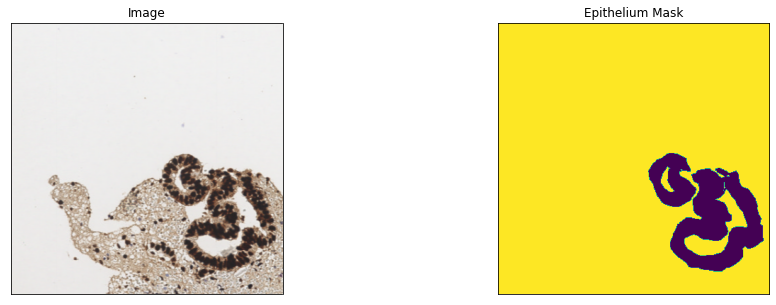

In [ ]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, pictures_string=train_string, classes=['epithelium'])

image, mask = dataset[100] # get some sample
visualize(
    image=image, 
    epithelium_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu
def get_pasha_augmentation():
    train_transform = [

        albu.RandomCrop(height=96, width=96, always_apply=True),
        
        albu.HorizontalFlip(p=0.5),

        albu.VerticalFlip(p=0.5),

        albu.ShiftScaleRotate(rotate_limit=90, shift_limit=0.01, p=1, border_mode=0 ),


        albu.IAAAdditiveGaussianNoise(p=0.2),
        
        albu.ElasticTransform()
        
    ]
    return albu.Compose(train_transform)        #albu.Lambda(mask=round_clip_0_1)

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.VerticalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.4, rotate_limit=120, shift_limit=0.4, p=1, border_mode=2),

        albu.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=2),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.1),
        #albu.IAAPerspective(p=1),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.8,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.8,
        ),
#
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
#
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)

def get_kek_augmentation():
    """Original image"""
    test_transform = [ albu.NoOp(always_apply=True, p=1) ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    #print(x.shape)
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.augmentations.transforms.Lambda(image=preprocessing_fn),
        albu.augmentations.transforms.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
len(train_dataset)

NameError: ignored

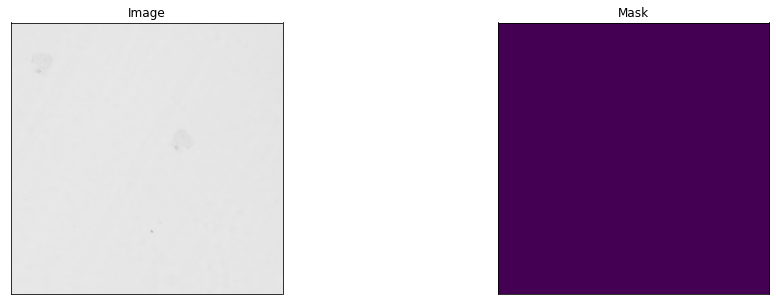

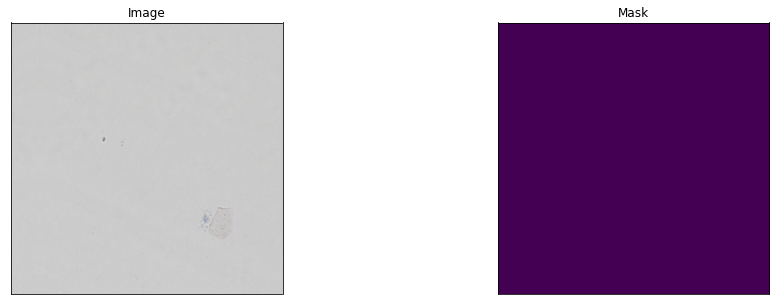

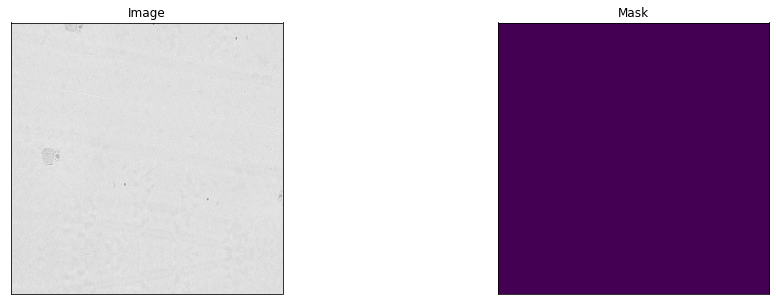

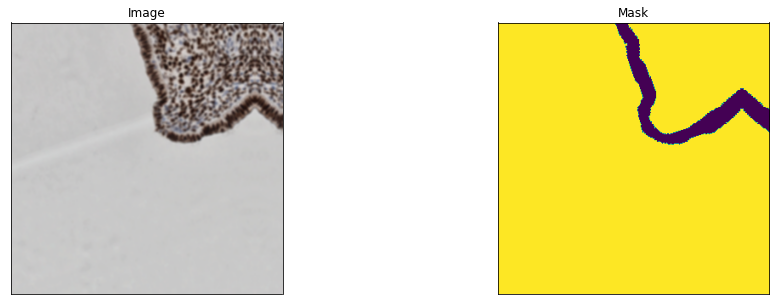

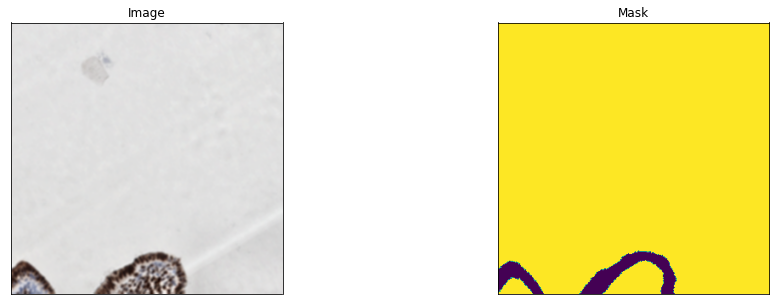

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    pictures_string=train_string,
    augmentation=get_training_augmentation(), 
    classes=['epithelium'],
)

# same image with different random transforms
for i in range(5):
    n = np.random.randint(0, len(augmented_dataset))
    image, mask = augmented_dataset[7]
    visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext101_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['epithelium']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder





In [ ]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [ ]:
!cp /content/drive/My\ Drive/main_model.pth /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
!cp /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth /content/drive/My\ Drive/main_model.pth 

In [ ]:

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    pictures_string=train_string,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    pictures_string=valid_string,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

In [ ]:
help(torch.ops)

TypeError: ignored

In [ ]:

# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index




optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.51),
]

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
import datetime
datetime.datetime.now()

datetime.datetime(2020, 8, 25, 6, 33, 58, 618511)

In [ ]:
def get_time():
    date_time = str(datetime.datetime.now())
    d, t = date_time.split(' ')
    print(d, t)
    d = d.split('-')
    t = t.split(':')
    kek = str((int(t[0]) + 3) % 24)
    
    #(y, m, d, h, mi, _, _) = datetime.date.today
    return d[0] + '_' + d[1] + '_' + d[2] + '_' + kek + '_' + t[1]

In [ ]:
start_time = get_time()
max_score = 0
'./' + start_time + '_with_' + str(max_score) + '_.pth'

2020-08-23 14:29:51.475317


'./2020_08_23_17_29_with_0_.pth'

In [ ]:
# train model for 40 epochs

max_score = 0
start_time = get_time()
for i in range(40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './' + start_time + '_' + str(max_score)[:6] + '.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

2020-08-25 06:34:16.845600

Epoch: 0
valid: 100%|██████████| 9/9 [00:13<00:00,  1.53s/it, dice_loss - 0.4381, iou_score - 0.4864]
Model saved!

Epoch: 1
valid: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s, dice_loss - 0.3024, iou_score - 0.6669]
Model saved!

Epoch: 2
valid: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, dice_loss - 0.2496, iou_score - 0.8156]
Model saved!

Epoch: 3
valid: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, dice_loss - 0.2267, iou_score - 0.8841]
Model saved!

Epoch: 4
valid: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s, dice_loss - 0.2058, iou_score - 0.9247]
Model saved!

Epoch: 5
valid: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s, dice_loss - 0.1899, iou_score - 0.9349]
Model saved!

Epoch: 6
valid: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s, dice_loss - 0.1739, iou_score - 0.9424]
Model saved!

Epoch: 7
valid: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s, dice_loss - 0.1666, iou_score - 0.9428]
Model saved!

Epoch: 8
valid: 100%|██████████| 9/9 [00:02<

In [ ]:
!cp 2020* /content/drive/My\ Drive

In [ ]:
best_model = torch.load('./2020_08_25_9_34_0.9626.pth')

In [ ]:
test_dataset_vis = Dataset(
    x_train_dir, y_train_dir, pictures_string=test_string,
    classes=CLASSES,
)

In [ ]:
!cp ./2020_08_20_13_47_0.9737789183855057_.pth ./drive/My\ Drive/

In [ ]:

# create test dataset
test_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    pictures_string=test_string,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)
#best_model = model

In [ ]:

# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 20/20 [00:49<00:00,  2.45s/it, dice_loss - 0.0522, iou_score - 0.9748]


(1536, 1536, 3)

False


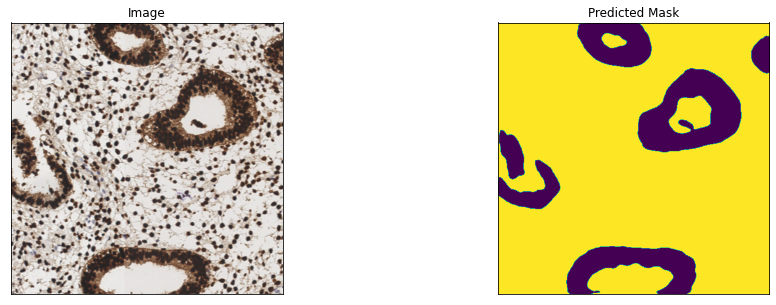

In [ ]:
im0 = cv2.imread('/content/drive/My Drive/1000576_train/391.png') #'/content/drive/My Drive/1000576_train/134.png')
im0 = im0[:, :, ::-1]
print(np.all(im0 == 255))
im0 = cv2.resize(im0, (512, 512), interpolation = cv2.INTER_CUBIC)
im0 = np.array(im0 / 255.0, dtype='float32')
x_tensor_0 = torch.from_numpy(im0.transpose(2, 0, 1)).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor_0)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
visualize(
    image=im0, 
    #ground_truth_mask=gt_mask, 
    predicted_mask=pr_mask
)

In [ ]:
train_string

'10.png 104.png 106.png 109.png 110.png 1105.png 111.png 1115.png 1116.png 1117.png 112.png 1126.png 1127.png 113.png 1131.png 1132.png 1134.png 114.png 116.png 117.png 118.png 119.png 12.png 124.png 126.png 127.png 128.png 129.png 13.png 130.png 131.png 133.png 134.png 135.png 136.png 137.png 138.png 139.png 141.png 143.png 145.png 146.png 147.png 149.png 166.png 167.png 171.png 172.png 178.png 179.png 188.png 189.png 203.png 204.png 228.png 229.png 23.png 233.png 234.png 239.png 24.png 255.png 256.png 257.png 261.png 262.png 264.png 265.png 266.png 267.png 269.png 270.png 272.png 273.png 274.png 276.png 277.png 279.png 28.png 281.png 282.png 287.png 29.png 293.png 294.png 312.png 313.png 317.png 318.png 322.png 323.png 324.png 34.png 345.png 351.png 352.png 354.png 364.png 378.png 379.png 383.png 384.png 385.png 386.png 387.png 389.png 390.png 392.png 393.png 394.png 395.png 396.png 397.png 398.png 399.png 427.png 428.png 429.png 432.png 433.png 434.png 468.png 469.png 472.png 473.pn

In [ ]:
cv2.imwrite('/content/drive/My Drive/1000576_mask/391_kek.png', pr_mask)

True

In [ ]:
pr_mask = np.array(pr_mask*255, dtype='uint8')

In [ ]:
t = cv2.imread('/content/drive/My Drive/1000576_mask/391.png')
t = np.bitwise_and(t, 1)
t.max()

0

In [ ]:
a = np.array([1, 2, 3])
b = np.array([3, 2, 1])
np.logical_or(a, b) * 255

array([255, 255, 255])

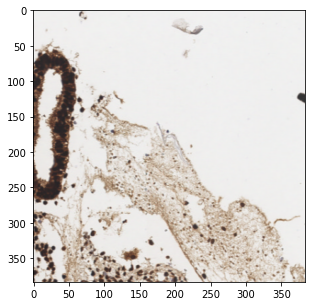

In [ ]:
image_show(image_vis)

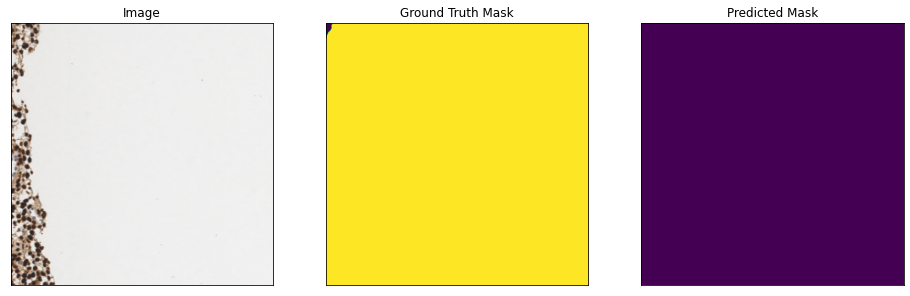

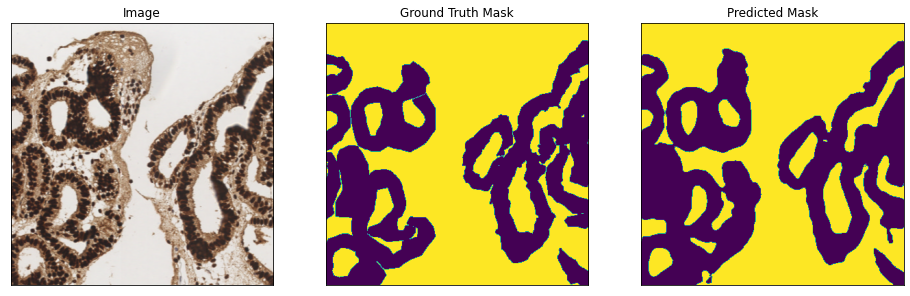

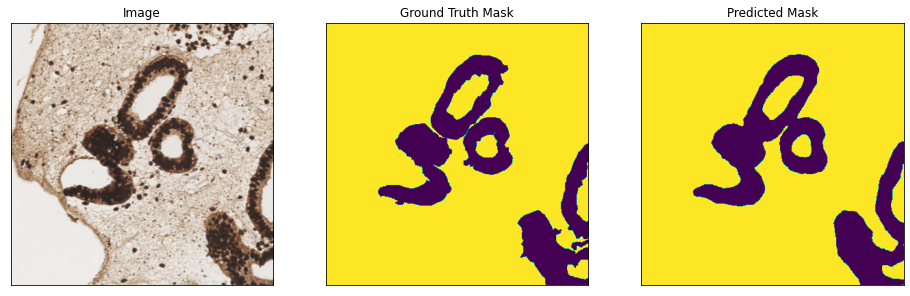

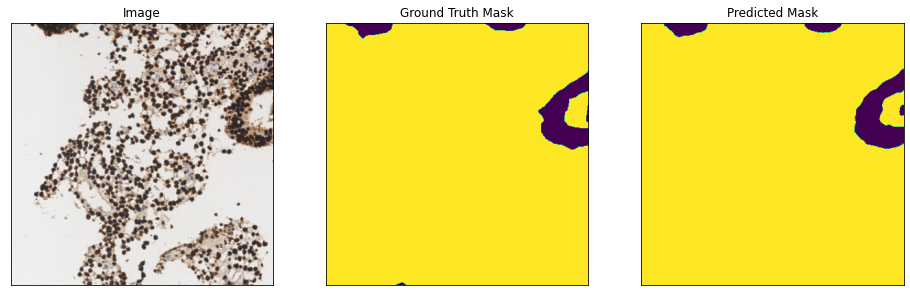

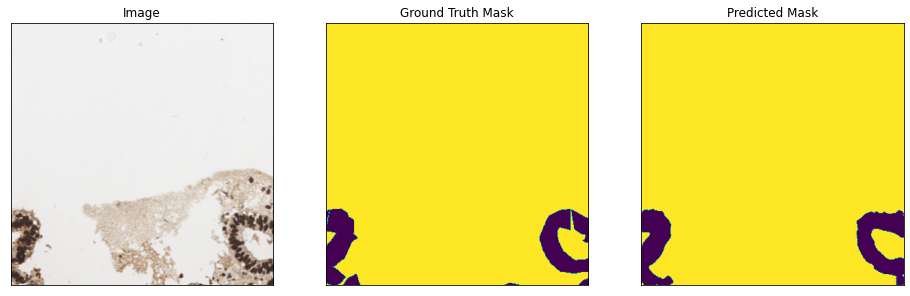

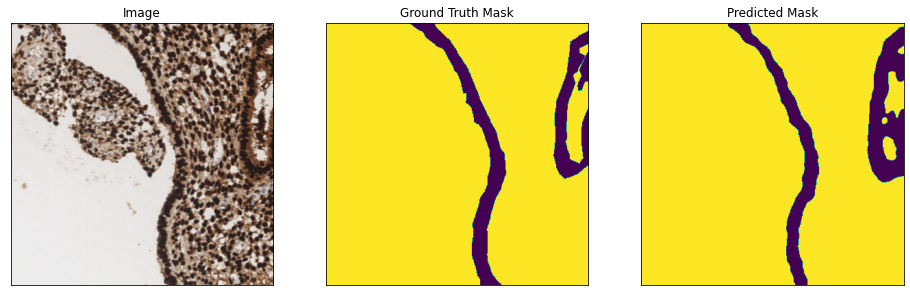

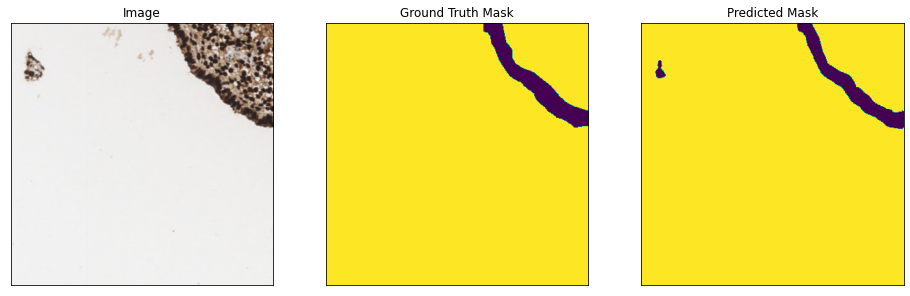

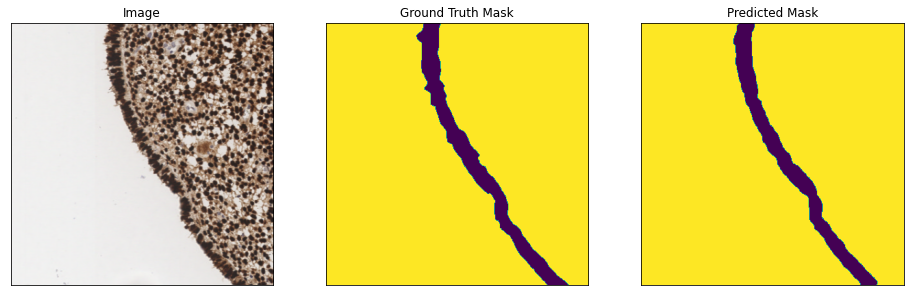

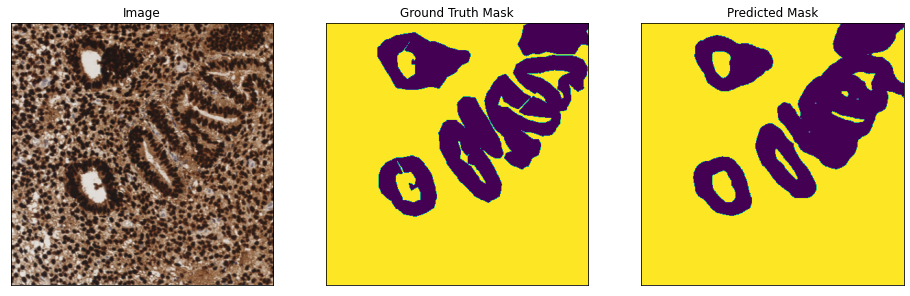

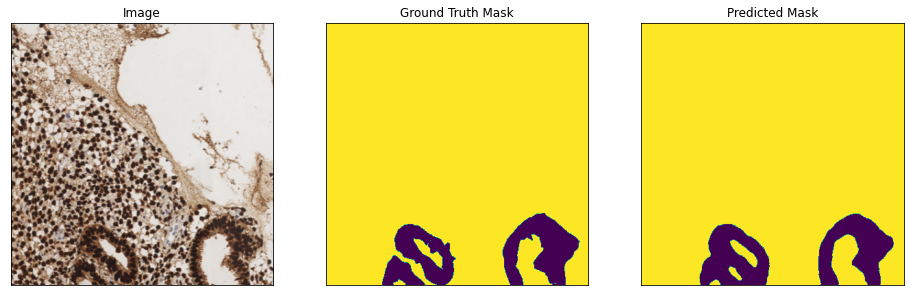

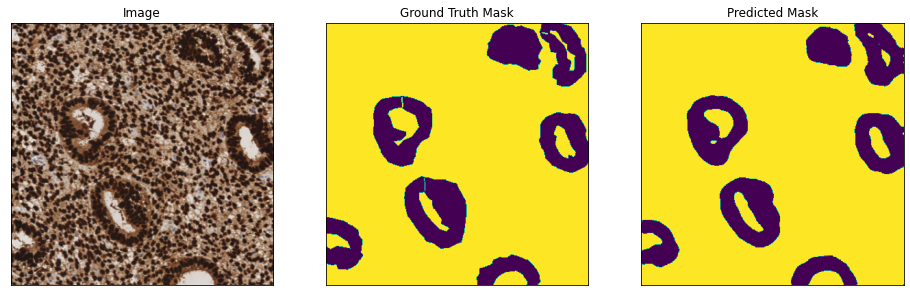

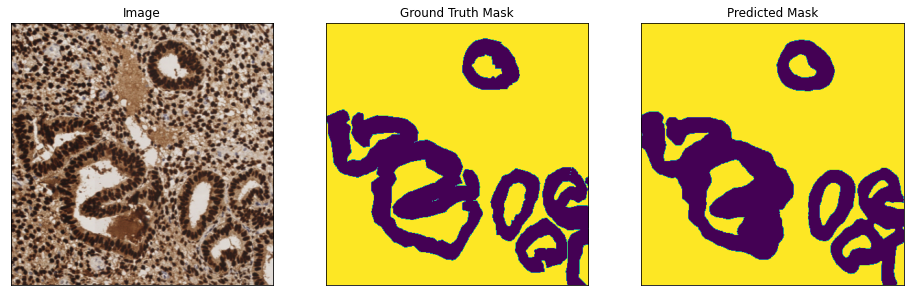

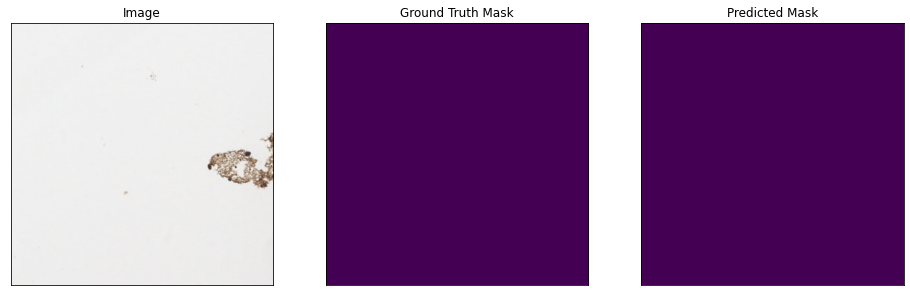

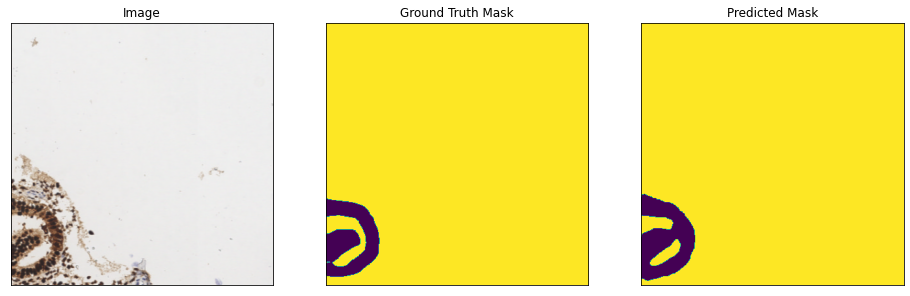

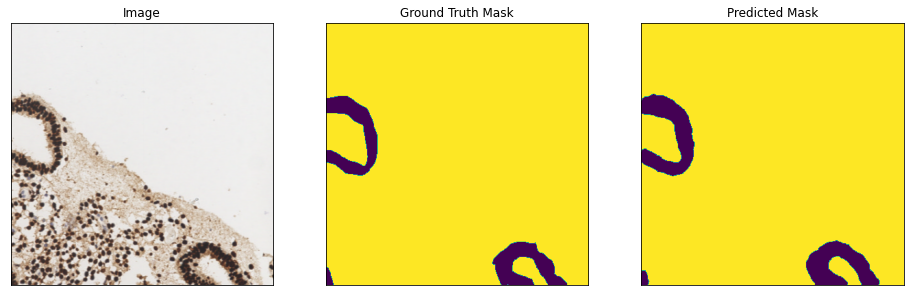

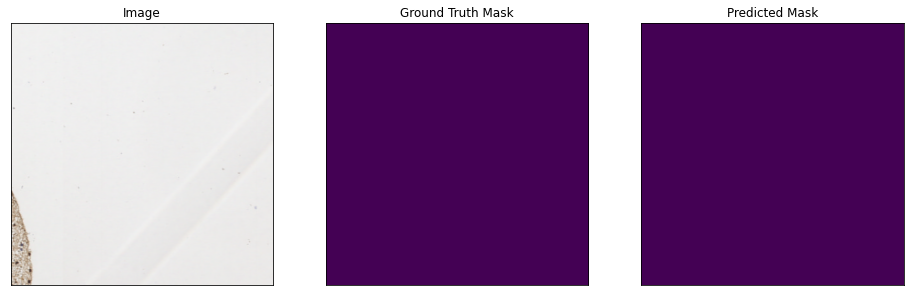

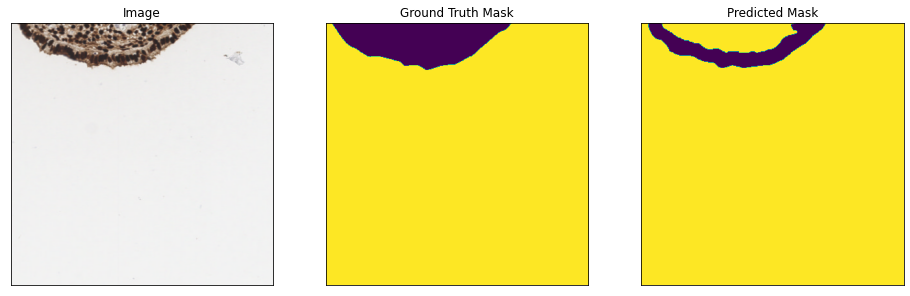

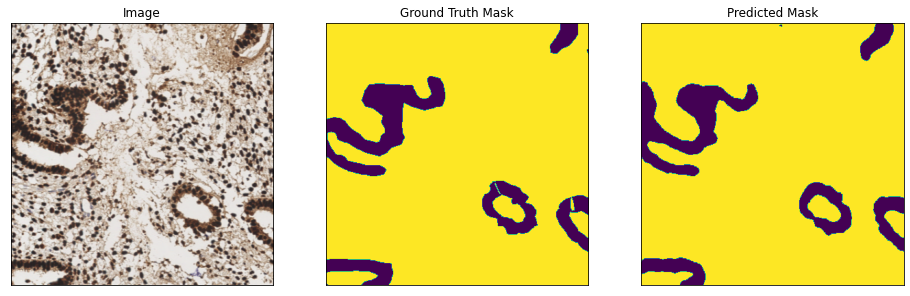

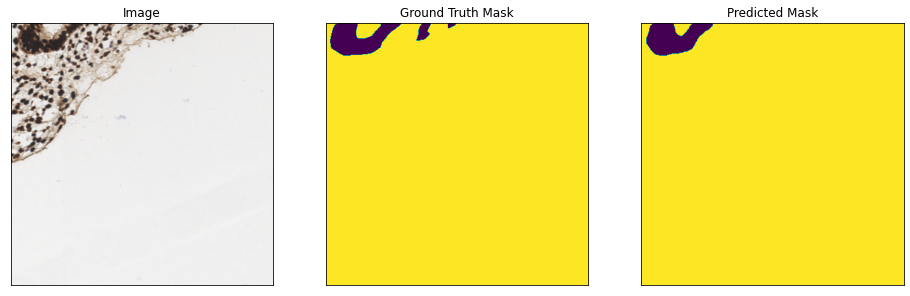

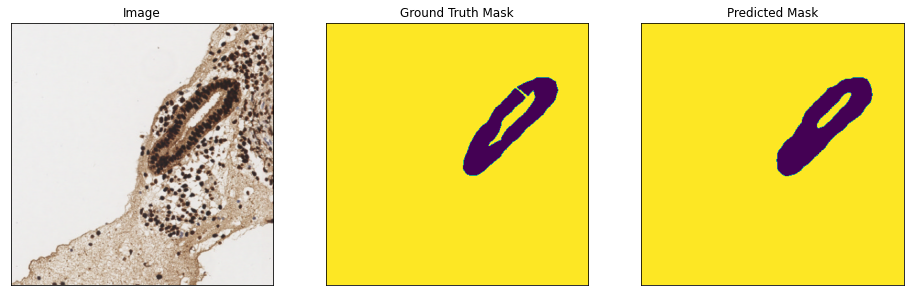

In [ ]:

for i in range(len(test_dataset)):
    #n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
!cp best_model2.pth drive/My\ Drive/very_best_model.pth